# **Introduccion**

El dataset a utilizar para esta tarea se encuentra en el siguiente link: https://www.kaggle.com/datasets/whenamancodes/fraud-detection 

Trata de una recopilación de transacciones realizadas con tarjetas de crédito, donde están definidas una serie de características continuas las transacciones como "V_i", estos son ponderadores de las transacciones para clasificar si cada una de estas transacciones son reales o fraudulentas. Además, se tiene el dato del monto gastado en dicha transacción.

Si bien el propósito original de este dataset es lograr predecir si una transacción es o no un fraude, por conveniencia, para la tarea se trabaja prediciendo el monto de la transacción. Esta decisión se tomó ya que la columna de fraude es binaria, lo que provoca que el cálculo de diferentes métricas de error careciese de sentido. Por esto, y dado que la columna "Amount" es de carácter continuo, es que en esta primera parte se predecira el monto de estas transacciones. Para esto se decide usar una proporción de 80:20 para la cantidad de datos de entrenamiento vs los datos de testeo.

# **KNN**


In [38]:
# Se carga drive para cargar el dataset posteriormente
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Iniciamos importando las librerias y modulos necesarios.

In [39]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import missingno as mno
#Modelo
from sklearn.neighbors import KNeighborsRegressor
#Errores
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [40]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tarea3IA/creditcard.csv')
df = df.iloc[0:81300]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81300 entries, 0 to 81299
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    81300 non-null  float64
 1   V1      81300 non-null  float64
 2   V2      81300 non-null  float64
 3   V3      81300 non-null  float64
 4   V4      81300 non-null  float64
 5   V5      81300 non-null  float64
 6   V6      81300 non-null  float64
 7   V7      81300 non-null  float64
 8   V8      81300 non-null  float64
 9   V9      81300 non-null  float64
 10  V10     81300 non-null  float64
 11  V11     81300 non-null  float64
 12  V12     81300 non-null  float64
 13  V13     81300 non-null  float64
 14  V14     81300 non-null  float64
 15  V15     81300 non-null  float64
 16  V16     81300 non-null  float64
 17  V17     81300 non-null  float64
 18  V18     81300 non-null  float64
 19  V19     81300 non-null  float64
 20  V20     81300 non-null  float64
 21  V21     81300 non-null  float64
 22

Realizamos una pequeña limpieza del dataset omitiendo la columna con valores NaN.

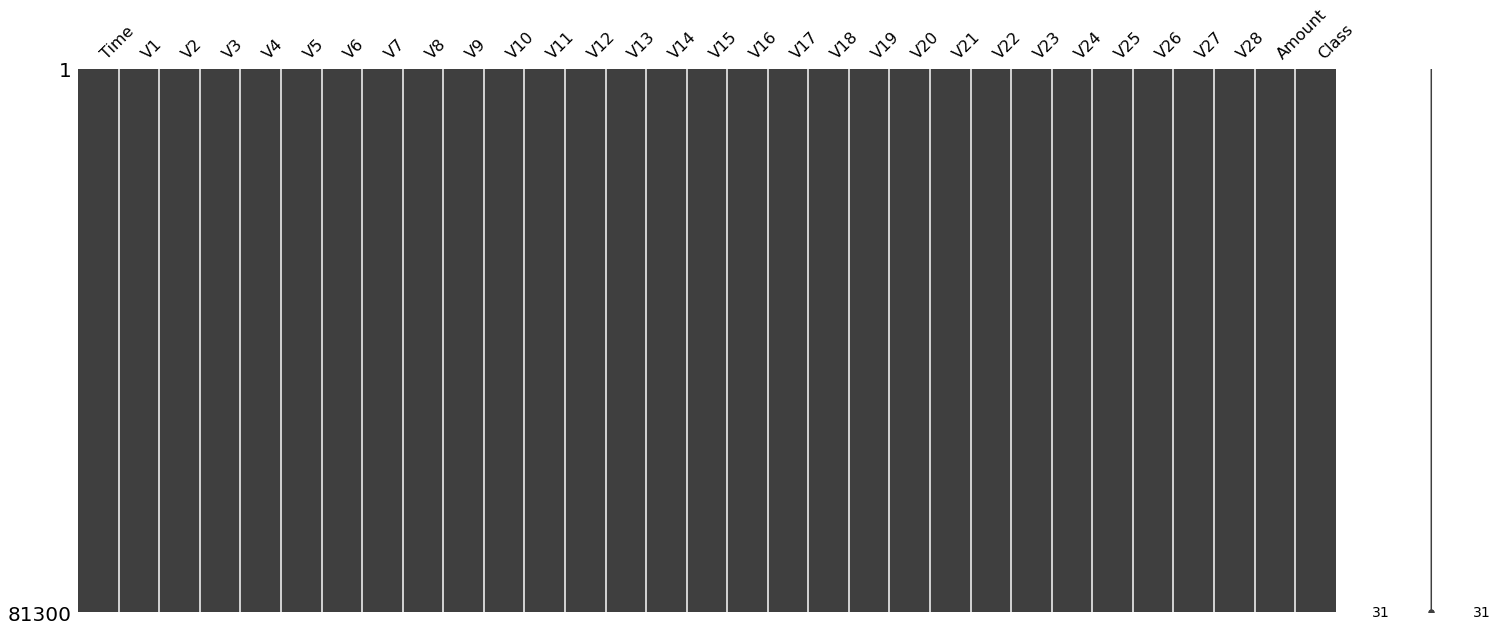

In [41]:
df = df.dropna(axis='index')
mno.matrix(df)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81300 entries, 0 to 81299
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    81300 non-null  float64
 1   V1      81300 non-null  float64
 2   V2      81300 non-null  float64
 3   V3      81300 non-null  float64
 4   V4      81300 non-null  float64
 5   V5      81300 non-null  float64
 6   V6      81300 non-null  float64
 7   V7      81300 non-null  float64
 8   V8      81300 non-null  float64
 9   V9      81300 non-null  float64
 10  V10     81300 non-null  float64
 11  V11     81300 non-null  float64
 12  V12     81300 non-null  float64
 13  V13     81300 non-null  float64
 14  V14     81300 non-null  float64
 15  V15     81300 non-null  float64
 16  V16     81300 non-null  float64
 17  V17     81300 non-null  float64
 18  V18     81300 non-null  float64
 19  V19     81300 non-null  float64
 20  V20     81300 non-null  float64
 21  V21     81300 non-null  float64
 22

Y verificamos que no existan valores NaN.

In [43]:
np.any(np.isnan(df))

False

Ahora, definimos nuestros características de entrenamiento, etiquetas de entrenamiento y características de testeo.

In [44]:
x_train = df.iloc[0:65040, 1:29]
x_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65035,-1.004616,0.671654,1.885887,0.071200,-0.742127,-0.204875,-0.253024,-0.148681,-1.328791,1.366522,...,-0.217253,-0.510902,-0.136318,-0.100592,0.121378,0.491960,-0.857235,-0.630246,-0.569884,0.229497
65036,-1.254337,-0.069769,1.909010,0.297547,-1.645904,0.211282,0.974873,-0.188754,-1.476755,0.492945,...,-0.410721,-0.173733,-0.423754,-0.575268,0.041816,0.361068,0.149746,-0.364912,0.423050,0.071534
65037,-0.683748,0.644364,-0.471090,-2.326885,1.950821,3.096047,-0.412611,1.384713,-0.192920,-0.824436,...,-0.394833,0.041182,-0.112265,-0.580014,0.003032,1.030196,-0.070451,0.740410,0.052551,-0.008286
65038,-1.470867,1.834489,0.485854,-0.037512,-0.285637,-0.611196,0.163954,0.670695,-0.329511,-0.201198,...,-0.521499,0.243176,-0.255653,-0.552043,0.089257,0.038275,-0.081743,0.083903,0.071950,-0.140812


In [45]:
y_train = df.iloc[0:65040]['Amount']
y_train

0        149.62
1          2.69
2        378.66
3        123.50
4         69.99
          ...  
65035      1.18
65036    318.11
65037      7.99
65038      9.99
65039      1.00
Name: Amount, Length: 65040, dtype: float64

In [46]:
x_test = df.iloc[65040:, 1:29]
x_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
65040,-2.293644,1.897379,0.312633,-0.656612,-1.065423,-0.935218,-0.470956,1.346193,-0.304884,-0.423819,...,-0.066117,-0.138024,-0.068046,-0.296996,0.202460,0.541799,-0.088955,0.272991,0.029918,0.084180
65041,-2.612167,1.384607,-0.099379,-2.542641,1.255802,-1.481799,1.360444,-1.148469,2.007792,1.136977,...,0.253777,-0.008239,-0.137828,0.248799,-0.770036,-0.403716,0.593529,-0.892587,-0.959080,0.104452
65042,-0.520170,0.238719,0.741449,-0.881755,0.620255,-1.146031,0.521511,-0.222363,-0.079252,-0.477687,...,-0.398602,-0.075163,0.093409,0.243519,0.230413,-0.048886,-1.124084,0.621160,-0.006569,0.272226
65043,1.192333,-0.254522,0.857514,0.620792,-0.516345,0.643615,-0.731835,0.277286,1.016914,-0.277931,...,-0.081690,-0.113583,-0.120290,-0.129523,-0.042336,-0.724184,0.285493,0.398617,0.030372,0.015394
65044,-0.125662,0.550636,2.197934,0.915299,0.021336,0.524887,0.170053,-0.025930,0.344930,-0.262850,...,0.885786,0.172284,-0.094626,0.120794,-0.284586,-0.424155,0.148760,-0.304613,-0.075485,-0.211846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81295,-0.438214,0.492120,2.440138,0.454998,-0.148495,0.476077,0.115241,0.232635,-0.057007,-0.069163,...,-0.606472,-0.044129,0.263317,0.865982,-0.093755,-0.026039,-0.602399,-0.453104,0.032011,-0.068108
81296,-0.473593,1.109975,1.704117,-0.019309,0.076774,-0.585510,0.718295,-0.023019,-0.619852,-0.393626,...,-0.476005,0.134036,-0.165078,-0.312285,0.027214,0.417189,-0.266886,0.076342,0.291547,0.123537
81297,-2.769864,1.253167,0.752106,0.455407,-1.894425,0.539661,1.081240,-0.188369,1.288851,0.413178,...,-0.542163,-1.246983,-0.139859,0.276332,0.232680,0.403653,-0.699800,-0.894091,-1.689498,-0.295784
81298,1.116529,-0.157694,-0.149952,1.059937,0.256352,0.774467,-0.132544,0.304707,0.402740,0.082820,...,0.360525,-0.176837,-0.122322,-0.341683,-0.235032,-1.192554,0.705936,-0.255435,0.013417,-0.002568


Ya teniendo definida las variables se busca calcular cual es la cantidad idónea de vecinos(K) a partir de la métrica score, la cual corresponde al coeficiente de determinación (R^2).

In [77]:
tagReal = pd.DataFrame(df.iloc[65040:]['Amount'])
for i in range(20):
  neigh = KNeighborsRegressor(i+1, metric = 'euclidean')
  neigh.fit(x_train, y_train)
  print(neigh.score(x_test, tagReal))

0.9048129998104266
0.9233621049749655
0.9316591136475084
0.9306622138748095
0.9265064332962121
0.9251988595334251
0.9239079764628364
0.9210753599821543
0.9179226642236563
0.9144573663213773
0.9127412657121982
0.9118628388017048
0.909164222219836
0.9055774659319837
0.9056450040492154
0.902791967151666
0.9003298653801539
0.8981150795834099
0.8958147920753813
0.8931112320794213


Dado los valores obtenidos es que se deciden usar 3 vecinos, ya que con esto se maximiza la precisión de modelo.

In [48]:
neigh = KNeighborsRegressor(n_neighbors=3, metric = 'euclidean')
neigh.fit(x_train,y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=3)

In [49]:
tagResult = neigh.predict(x_test)
tagReal = pd.DataFrame(df.iloc[65040:]['Amount'])

In [50]:
tagReal

,Amount
65040,1.00
65041,6.04
65042,10.00
65043,11.50
65044,9.99
...,...
81295,17.85
81296,0.89
81297,245.00
81298,52.86


In [51]:
tagResult = pd.DataFrame(tagResult).rename(columns={0: "Amount"})
tagResult

,Amount
0,1.000000
1,0.923333
2,25.476667
3,29.330000
4,7.663333
...,...
16255,28.306667
16256,5.806667
16257,191.500000
16258,45.093333


In [52]:
neigh.score(x_test, tagReal)

0.9316591136475084

In [53]:
print('Error maximo:',max_error(tagReal, tagResult))
print('Error cuadratico medio:',mean_squared_error(tagReal, tagResult))
print('Error absoluto mediano:',median_absolute_error(tagReal, tagResult))

Error maximo: 2200.7
Error cuadratico medio: 4814.671761186278
Error absoluto mediano: 16.90166666666667


Como vemos, cada unos de estos errores nos dan realimentación sobre nuestro modelo. Podemos observar que la mayor distancía de error fue de 2200.7. Por otra parte, tenemos el error cuadratico medio con un valor de 4814.6 que nos dice que en promedio el error al cuadrado fue de 4814. Finalmente, con el error aboluto mediano podemos obtener la mediana de los valores de error que tuvo un valor de 16.9.

# **Regresión Lineal**


Importamos el modelo y el error.

In [54]:
#Modelo
from sklearn import linear_model
#Error
from sklearn.metrics import mean_squared_error

Definimos nuestro conjunto de entrenamieto y predicción.

In [55]:
x_train = df.iloc[0:65040, 1:29]
y_train = df.iloc[0:65040]['Amount']
x_test = df.iloc[65040:, 1:29]

Se entrena la regresión con los valores definidos.

In [56]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

Y se calcula la etiqueta de las caracteristicas.

In [57]:
tagResultLR = reg.predict(x_test)

In [58]:
reg.score(x_test, tagReal)

0.8682733161043353

In [59]:
print('Error cuadratico medio:',mean_squared_error(tagReal, tagResultLR))

Error cuadratico medio: 9280.253432417561


Como se observa, al comparar el error absoluto mediano entre la regresión lineal y KNN, concluimos que KNN funciono mucho más ajustado tanto al revisar el score como al ver el error. Esto se debe a que la proporsión de datos usados para entrenar los algoritmos benefician claramente a KNN. Sin embargo, cuando revisamos el error absoluto mediano de la regresión lineal este tiene un porcentaje menor de error en comparación a KNN, concluyendo que cuando KNN se entrena con una gran cantidad de datos este modelo se ajusta mejor que una regresión, y los errores de la regresión lineal son mucho más alejados del valor esperado.

# **GMM y DBSCAN** 

Para esta parte, usaremos la misma proporción utilizada anteriormente, pero ahora usaremos solamente la columna "V1" y "Amount". Con esto logramos observar graficamente GMM y DBSCAN

In [60]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import missingno as mno
import seaborn as sns
#Modelo
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#Error
from sklearn.metrics import mean_squared_error

Ahora, calculamos la cantidad de componentes o clusters a usar en el modelo GMM. Para esto buscaremos el menor 'Bayesian Information Criterion' (BIC), el cual es un criterio que indica que tan bien se  ajustan los datos al modelo dado un número de clusters, de modo que mientras más bajo, más preciso.

In [61]:
Z = df[['V4', 'V9']].values
Z_train, Z_test = train_test_split(Z, train_size=0.8, random_state=1)

In [76]:
n_clusters = range(25,55) #El rango fue reducido puesto que en una primera ejecución calculamos del 1 al 100, y ya conociendo el valor ideal es que redujimos a 25-55
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Z_train) for n in tqdm(n_clusters)]


100%|██████████| 30/30 [02:26<00:00,  4.88s/it]


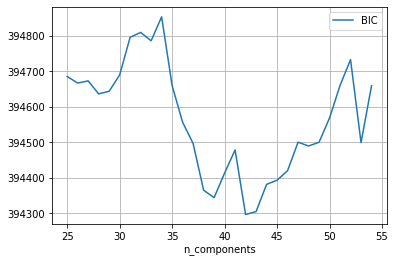

  0%|          | 0/30 [00:24<?, ?it/s]


In [64]:
plt.plot(n_clusters, [m.bic(Z_train) for m in models], label='BIC')
#plt.plot(n_clusters, [m.aic(Z_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.grid()

Concluimos que la mejor cantidad de componentes es de 42.

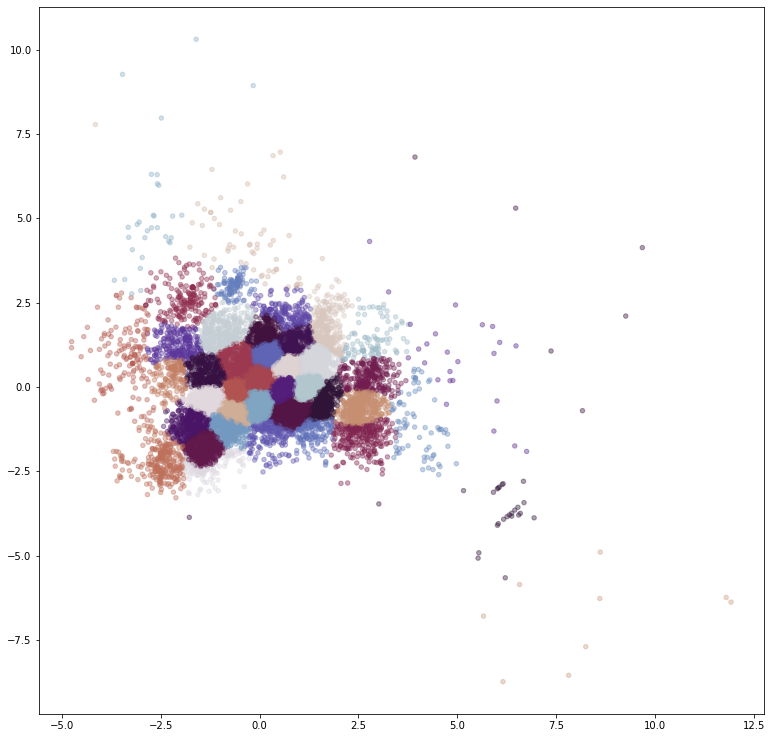

In [73]:
gm = GaussianMixture(42, covariance_type='full', random_state=0).fit(Z_train)
y_prediction_gm = gm.predict(Z_test)
fig, ax = plt.subplots()
fig.set_figwidth(13)
fig.set_figheight(13)
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=y_prediction_gm, s=20, alpha=0.4, cmap='twilight_shifted');

Ahora, calculamos el epsilon para esto graficamos los n-vecinos más cercanos en base al algoritmo NN, con este encontramos la relación entre la distancia (epsilon) y la cantidad de puntos que logra abarcar.

Text(0, 0.5, 'Distance')

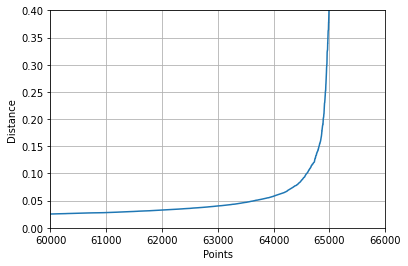

In [66]:
k = 2

# Calculate NN
neighbors = NearestNeighbors(n_neighbors=k).fit(Z_train)
distances, indices = neighbors.kneighbors(Z_train)
distances = np.sort(distances, axis=0)

# Get distances
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i, 
    y = distances

)
plt.axis([60000, 66000, 0, 0.4])
plt.grid()
plt.xlabel("Points")
plt.ylabel("Distance")

Con esto concluimos que un buen número para el epsilon es 0.075 y dejaremos la cantidad de vecinos default. (5)

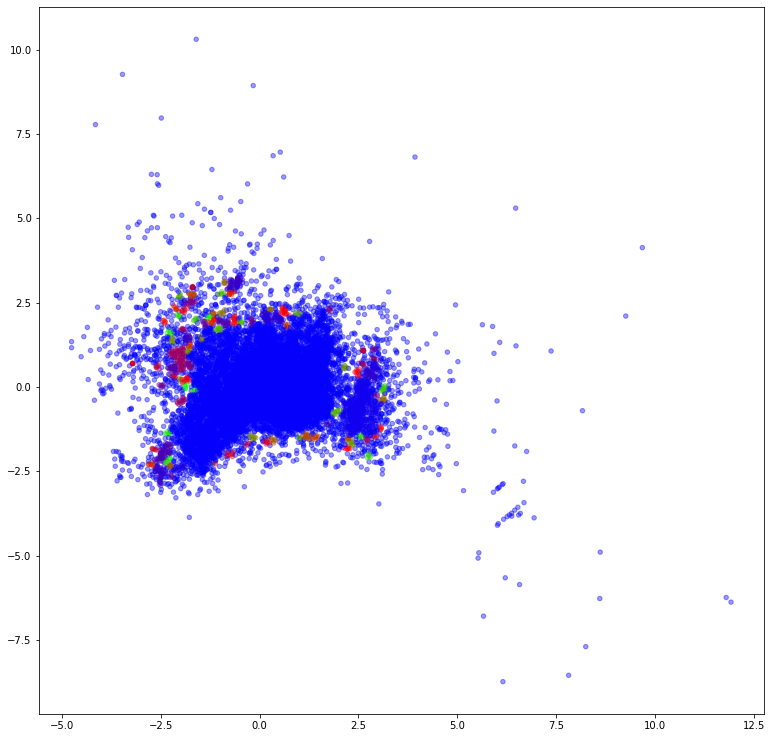

In [74]:
clustering = DBSCAN(eps=0.075).fit_predict(Z_test)
fig, ax = plt.subplots()
fig.set_figwidth(13)
fig.set_figheight(13)
plt.scatter(Z_test[:, 0], Z_test[:, 1], c=clustering, s=20, alpha=0.4, cmap='brg')

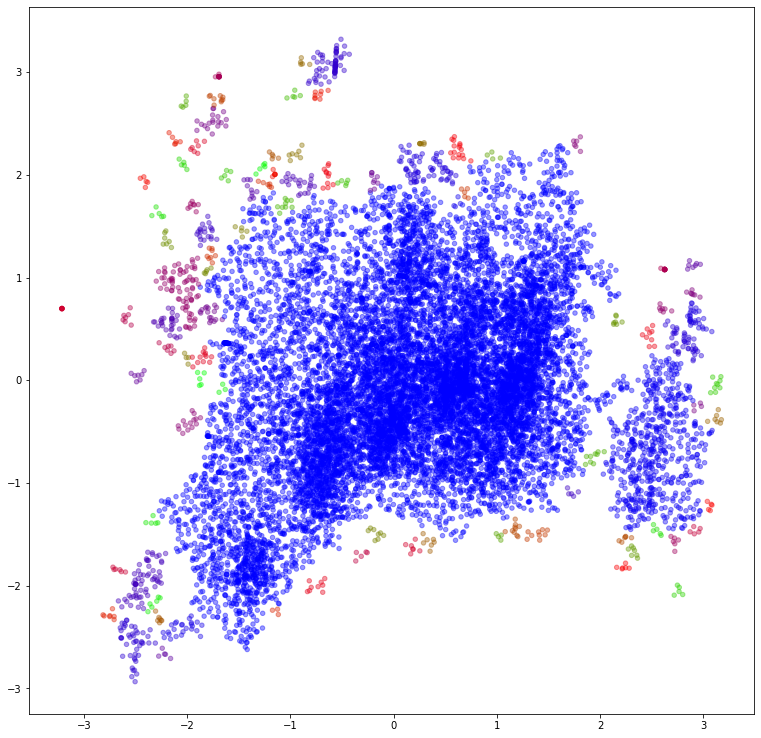

In [75]:
dbscan = DBSCAN(eps=0.075).fit_predict(Z_test)
labels = dbscan[0]
count = 0
index = 0

for i in range(len(dbscan)):
  if i != 0:
    if dbscan[i] != -1:
      labels = np.append(labels, dbscan[i])
      index = np.append(index, i) 

Z_test_plot = np.zeros((len(labels),2))
for i in range(len(labels)):
  Z_test_plot[i] = Z_test[index[i]]
fig, ax = plt.subplots()
fig.set_figwidth(13)
fig.set_figheight(13)
plt.scatter(Z_test_plot[:, 0], Z_test_plot[:, 1], c=labels, s=20, alpha=0.4, cmap='brg')

In [71]:
n_clusters_ = len(set(clustering)) - (1 if -1 in clustering else 0)
n_noise_ = list(clustering).count(-1)
print('Cantidad de Clusters:', n_clusters_)
print('Cantidad de outlier:', n_noise_)

Cantidad de Clusters: 92
Cantidad de outlier: 1535


Se puede ver que ambos algoritmos son de clustering, en el sentido de que ambos generan clusters de puntos, sin embargo podemos diferenciar que GMM genera los clusters según la cantidad definida por nosotros, mientras que DBSCAN genera los clusters en función del epsilon. Además, GMM nos da información como la cantidad de clusters o sub-grupos que comparten relación, mientras que DBSCAN nos da información sobre la cantidad de outliers y sobre que tan densos son nuestros clusters.

Ahora, al observar el grafico observamos la principal diferencia entre DBSCAN y GMM, donde DBSCAN nos muestra la densidad que existe en los clusters, teniendo un gran cluster extremadamente denso y otros cluster más pequeños, mientras que GMM nos genera pequeños clusters con una cantidad casi homogenea de estos.